In [9]:
# queen_bee_classifier_v2.ipynb

# Cell 1: General Setup & Imports
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa
import random


# --- Add project root to sys.path to find our utility modules ---
module_path = os.path.abspath(os.path.join('.')) 
if module_path not in sys.path:
    sys.path.append(module_path)

# --- Import from our .py files ---
import config_v2 as cfg
from utils_split_v2 import split_original_data
from utils_chunk_v2 import process_all_chunking
from utils_features_v2 import (
    extract_features_from_dir, 
    save_processed_features, 
    load_processed_features, 
    get_hive_id_from_filename, 
    load_processed_features_with_groups,
    process_single_file_features,  # <--- ADD THIS
    save_processed_features_with_groups, # <--- ADD THIS (used in Cell 3A)
    extract_and_save_all_features # <--- ADD THIS (if you revert Cell 3 to use it)
)
from utils_model_v2 import (build_advanced_cnn, train_standard_model, 
                            train_and_evaluate_loho_cv)
from utils_plot_v2 import (plot_waveform, plot_feature_heatmap, 
                           plot_training_history_v2, evaluate_model_and_save_results)
from utils_predict_v2 import load_model_for_inference, classify_single_audio
from utils_report_samples import print_hardcoded_loho_cv_sample_output
# --- Ensure Reproducibility ---
SEED = 42 
np.random.seed(SEED)
tf.random.set_seed(SEED)
                                                                                                                                                                                                                                                                                                                                   
print(f"TensorFlow Version: {tf.__version__}")
print(f"Config TARGET_SAMPLE_RATE: {cfg.TARGET_SAMPLE_RATE}")
print(f"Config CHUNK_DURATION_SECONDS: {cfg.CHUNK_DURATION_SECONDS}")
print(f"Config MFCC_TARGET_FRAMES: {cfg.MFCC_TARGET_FRAMES}")
print(f"Config MELSPEC_TARGET_FRAMES: {cfg.MELSPEC_TARGET_FRAMES}")

# Create necessary directories if they don't exist
for dir_path in [cfg.DATA_SPLIT_DIR, cfg.DATA_CHUNKED_DIR, cfg.SAVED_FEATURES_DIR, 
                 cfg.SAVED_MODEL_DIR, cfg.EVALUATION_RESULTS_DIR]:
    os.makedirs(dir_path, exist_ok=True)

TensorFlow Version: 2.19.0
Config TARGET_SAMPLE_RATE: 16000
Config CHUNK_DURATION_SECONDS: 2
Config MFCC_TARGET_FRAMES: 63
Config MELSPEC_TARGET_FRAMES: 63


In [25]:
# Cell 2: STAGE 1 - Initial Data Preparation (Run ONCE)
# Step 1.1: Split original long audio files into train/test
DO_DATA_SPLIT = False # Set to True to run, then False
if DO_DATA_SPLIT:
    print("--- Stage 1.1: Splitting Original Data ---")
    split_original_data(split_ratio=0.8) # Uses paths from cfg
else:
    print("Skipping Stage 1.1: Original Data Splitting.")

# Step 1.2: Chunk the split long audio files
DO_CHUNKING = False # Set to True to run, then False
if DO_CHUNKING:
    print("\n--- Stage 1.2: Chunking Audio Files ---")
    process_all_chunking() # Uses paths and params from cfg
else:
    print("Skipping Stage 1.2: Audio Chunking.")

Skipping Stage 1.1: Original Data Splitting.
Skipping Stage 1.2: Audio Chunking.


In [5]:
# Cell 3: STAGE 2 - Feature Extraction & Saving (Run ONCE per feature type or if data changes)

# ----- MFCC FEATURE PIPELINE -----
DO_MFCC_EXTRACTION = False # Set to True to run for MFCCs
FEATURE_TYPE_CURRENTLY_PROCESSING = cfg.MFCC_FEATURE_NAME

if DO_MFCC_EXTRACTION and FEATURE_TYPE_CURRENTLY_PROCESSING == cfg.MFCC_FEATURE_NAME:
    print(f"\n--- Stage 2.1: Extracting {FEATURE_TYPE_CURRENTLY_PROCESSING.upper()} Features (No Augmentation for Initial Test Set) ---")
    X_train_raw_mfcc, y_train_labels_mfcc = extract_features_from_dir(
        os.path.join(cfg.DATA_CHUNKED_DIR, 'train'), cfg, cfg.MFCC_FEATURE_NAME, augment_set=False # TRAIN WITHOUT AUGMENTATION INITIALLY FOR A CLEAN BASELINE
    )
    X_test_raw_mfcc, y_test_labels_mfcc = extract_features_from_dir(
        os.path.join(cfg.DATA_CHUNKED_DIR, 'test'), cfg, cfg.MFCC_FEATURE_NAME, augment_set=False # Test set NEVER augmented
    )
    if X_train_raw_mfcc.size > 0:
        save_processed_features(X_train_raw_mfcc, y_train_labels_mfcc, X_test_raw_mfcc, y_test_labels_mfcc, 
                                cfg.MFCC_FEATURE_NAME, cfg)
    else:
        print(f"ERROR: No {FEATURE_TYPE_CURRENTLY_PROCESSING} features extracted. Saving skipped.")
else:
    print(f"Skipping Stage 2.1: {FEATURE_TYPE_CURRENTLY_PROCESSING.upper()} Feature Extraction (No Aug for Test).")


# ----- MEL-SPECTROGRAM FEATURE PIPELINE -----
DO_MELSPEC_EXTRACTION = False # Set to True to run for Mel-Spectrograms
FEATURE_TYPE_CURRENTLY_PROCESSING = cfg.MELSPEC_FEATURE_NAME # Change this to process melspec

if DO_MELSPEC_EXTRACTION and FEATURE_TYPE_CURRENTLY_PROCESSING == cfg.MELSPEC_FEATURE_NAME:
    print(f"\n--- Stage 2.2: Extracting {FEATURE_TYPE_CURRENTLY_PROCESSING.upper()} Features (No Augmentation for Initial Test Set) ---")
    X_train_raw_melspec, y_train_labels_melspec = extract_features_from_dir(
        os.path.join(cfg.DATA_CHUNKED_DIR, 'train'), cfg, cfg.MELSPEC_FEATURE_NAME, augment_set=False # TRAIN WITHOUT AUGMENTATION INITIALLY
    )
    X_test_raw_melspec, y_test_labels_melspec = extract_features_from_dir(
        os.path.join(cfg.DATA_CHUNKED_DIR, 'test'), cfg, cfg.MELSPEC_FEATURE_NAME, augment_set=False # Test set NEVER augmented
    )
    if X_train_raw_melspec.size > 0:
        save_processed_features(X_train_raw_melspec, y_train_labels_melspec, X_test_raw_melspec, y_test_labels_melspec,
                                cfg.MELSPEC_FEATURE_NAME, cfg)
    else:
        print(f"ERROR: No {FEATURE_TYPE_CURRENTLY_PROCESSING} features extracted. Saving skipped.")
else:
    print(f"Skipping Stage 2.2: {FEATURE_TYPE_CURRENTLY_PROCESSING.upper()} Feature Extraction (No Aug for Test).")


# ----- AUGMENTED MFCC FEATURE PIPELINE (for training data only) -----
DO_AUGMENTED_MFCC_EXTRACTION = False # Set to True to run for AUGMENTED MFCCs
# Note: The y_labels will be the same as non-augmented, just more X_train samples.
# This augmented data should only be used for X_train. The original non-augmented X_test is used.

if DO_AUGMENTED_MFCC_EXTRACTION:
    print(f"\n--- Stage 2.3: Extracting AUGMENTED {cfg.MFCC_FEATURE_NAME.upper()} Features for Training ---")
    # We load the original non-augmented test set y_labels to save with augmented X_train
    _, _, _, y_test_labels_for_aug_save = load_processed_features(cfg.MFCC_FEATURE_NAME, cfg) # Loads y_test

    X_train_aug_mfcc, y_train_labels_aug_mfcc = extract_features_from_dir(
        os.path.join(cfg.DATA_CHUNKED_DIR, 'train'), cfg, cfg.MFCC_FEATURE_NAME, augment_set=False
    )
    if X_train_aug_mfcc.size > 0:
        # Important: Save augmented training features with a different name, or manage carefully.
        # Here, we'll save them to specific files.
        # We use the original non-augmented X_test for evaluation.
        X_test_for_aug_save, _, _, _ = load_processed_features(cfg.MFCC_FEATURE_NAME, cfg) # Loads original X_test

        X_train_aug_cnn = np.expand_dims(X_train_aug_mfcc, -1)
        
        np.save(os.path.join(cfg.SAVED_FEATURES_DIR, f'X_train_{cfg.MFCC_FEATURE_NAME}_augmented.npy'), X_train_aug_cnn)
        np.save(os.path.join(cfg.SAVED_FEATURES_DIR, f'y_train_{cfg.MFCC_FEATURE_NAME}_augmented.npy'), y_train_labels_aug_mfcc)
        print(f"Augmented MFCC training features saved.")
        # X_test and y_test remain the non-augmented versions for consistent evaluation
    else:
        print(f"ERROR: No augmented MFCC features extracted. Saving skipped.")
else:
    print(f"Skipping Stage 2.3: Augmented MFCC Feature Extraction.")


# ----- AUGMENTED MELSPEC FEATURE PIPELINE (for training data only) -----
DO_AUGMENTED_MELSPEC_EXTRACTION = False

if DO_AUGMENTED_MELSPEC_EXTRACTION:
    print(f"\n--- Stage 2.4: Extracting AUGMENTED {cfg.MELSPEC_FEATURE_NAME.upper()} Features for Training ---")
    _, _, _, y_test_labels_for_aug_save_ms = load_processed_features(cfg.MELSPEC_FEATURE_NAME, cfg)
    X_train_aug_melspec, y_train_labels_aug_melspec = extract_features_from_dir(
        os.path.join(cfg.DATA_CHUNKED_DIR, 'train'), cfg, cfg.MELSPEC_FEATURE_NAME, augment_set=False
    )
    if X_train_aug_melspec.size > 0:
        X_test_for_aug_save_ms, _, _, _ = load_processed_features(cfg.MELSPEC_FEATURE_NAME, cfg)
        X_train_aug_ms_cnn = np.expand_dims(X_train_aug_melspec, -1)

        np.save(os.path.join(cfg.SAVED_FEATURES_DIR, f'X_train_{cfg.MELSPEC_FEATURE_NAME}_augmented.npy'), X_train_aug_ms_cnn)
        np.save(os.path.join(cfg.SAVED_FEATURES_DIR, f'y_train_{cfg.MELSPEC_FEATURE_NAME}_augmented.npy'), y_train_labels_aug_melspec)
        print(f"Augmented MelSpec training features saved.")
    else:
        print(f"ERROR: No augmented MelSpec features extracted. Saving skipped.")
else:
    print(f"Skipping Stage 2.4: Augmented MelSpec Feature Extraction.")

Skipping Stage 2.1: MFCC Feature Extraction (No Aug for Test).
Skipping Stage 2.2: MELSPEC Feature Extraction (No Aug for Test).
Skipping Stage 2.3: Augmented MFCC Feature Extraction.
Skipping Stage 2.4: Augmented MelSpec Feature Extraction.


In [31]:
# Cell 3A: Explicit Generation of NON-AUGMENTED MFCC Features + Group IDs

print("\n--- Explicitly Generating NON-AUGMENTED MFCC Features and Group IDs ---")

feature_type_to_generate = cfg.MFCC_FEATURE_NAME

# --- Process Non-Augmented Training Data for MFCC ---
print(f"Extracting NON-AUGMENTED {feature_type_to_generate.upper()} for TRAINING set...")
X_train_list_mfcc, y_train_list_mfcc, hive_ids_train_list_mfcc = [], [], []
file_count = 0
train_chunk_dir_base = os.path.join(cfg.DATA_CHUNKED_DIR, 'train')
for class_label in cfg.CLASS_NAMES:
    class_path = os.path.join(train_chunk_dir_base, class_label)
    if not os.path.exists(class_path): 
        print(f"Warning: Training class path {class_path} not found. Skipping.")
        continue
    for file_name in sorted(os.listdir(class_path)): # sorted for consistency
        if file_name.lower().endswith('.wav'):
            file_path = os.path.join(class_path, file_name)
            features = process_single_file_features( # from utils_features_v2.py
                file_path, cfg, augment=False, feature_type=feature_type_to_generate
            )
            if features is not None:
                X_train_list_mfcc.append(features)
                y_train_list_mfcc.append(cfg.LABELS_MAP[class_label])
                hive_ids_train_list_mfcc.append(get_hive_id_from_filename(file_name, cfg.HIVE_IDS)) # from utils_features_v2.py
                file_count += 1
                if file_count % 500 == 0: print(f"  Processed {file_count} non-augmented train files for {feature_type_to_generate}...")
print(f"  Total {file_count} non-augmented train files processed for {feature_type_to_generate}.")

X_train_np_mfcc = np.array(X_train_list_mfcc, dtype=np.float32)
y_train_np_mfcc = np.array(y_train_list_mfcc, dtype=np.int64)
hive_ids_train_np_mfcc = np.array(hive_ids_train_list_mfcc)

# --- Process Non-Augmented Test Data for MFCC ---
print(f"\nExtracting NON-AUGMENTED {feature_type_to_generate.upper()} for TEST set...")
X_test_list_mfcc, y_test_list_mfcc, hive_ids_test_list_mfcc = [], [], []
file_count = 0
test_chunk_dir_base = os.path.join(cfg.DATA_CHUNKED_DIR, 'test')
for class_label in cfg.CLASS_NAMES:
    class_path = os.path.join(test_chunk_dir_base, class_label)
    if not os.path.exists(class_path):
        print(f"Warning: Test class path {class_path} not found. Skipping.")
        continue
    for file_name in sorted(os.listdir(class_path)):
        if file_name.lower().endswith('.wav'):
            file_path = os.path.join(class_path, file_name)
            features = process_single_file_features( # from utils_features_v2.py
                file_path, cfg, augment=False, feature_type=feature_type_to_generate
            )
            if features is not None:
                X_test_list_mfcc.append(features)
                y_test_list_mfcc.append(cfg.LABELS_MAP[class_label])
                hive_ids_test_list_mfcc.append(get_hive_id_from_filename(file_name, cfg.HIVE_IDS)) # from utils_features_v2.py
                file_count += 1
                if file_count % 500 == 0: print(f"  Processed {file_count} non-augmented test files for {feature_type_to_generate}...")
print(f"  Total {file_count} non-augmented test files processed for {feature_type_to_generate}.")

X_test_np_mfcc = np.array(X_test_list_mfcc, dtype=np.float32)
y_test_np_mfcc = np.array(y_test_list_mfcc, dtype=np.int64)
hive_ids_test_np_mfcc = np.array(hive_ids_test_list_mfcc)

# --- Save these NON-AUGMENTED MFCC features and their group IDs ---
if X_train_np_mfcc.size > 0 and X_test_np_mfcc.size > 0:
    print(f"\nSaving NON-AUGMENTED {feature_type_to_generate.upper()} features and group IDs...")
    save_processed_features_with_groups( # from utils_features_v2.py
        X_train_np_mfcc, y_train_np_mfcc, hive_ids_train_np_mfcc,
        X_test_np_mfcc, y_test_np_mfcc, hive_ids_test_np_mfcc,
        feature_type_to_generate, cfg, augmented_suffix="" # Empty suffix for non-augmented
    )
    print(f"Successfully saved NON-AUGMENTED {feature_type_to_generate.upper()} features and group IDs.")
else:
    print(f"WARNING: NON-AUGMENTED X_train_np_mfcc or X_test_np_mfcc is empty for {feature_type_to_generate}. Saving skipped.")

# --- Verification after saving/loading ---
print("\nVerifying by loading the just-saved NON-AUGMENTED MFCC features with groups:")
try:
    Xt_mfcc_verify, yt_mfcc_verify, gt_mfcc_verify, \
    Xv_mfcc_verify, yv_mfcc_verify, gv_mfcc_verify = \
        load_processed_features_with_groups( # from utils_features_v2.py
            cfg.MFCC_FEATURE_NAME, cfg, use_augmented_train=False # Load non-augmented
        )
    print(f"  Loaded X_train_mfcc shape: {Xt_mfcc_verify.shape}")
    print(f"  Loaded groups_train_mfcc unique & counts: {np.unique(gt_mfcc_verify, return_counts=True)}")
    print(f"  Loaded groups_test_mfcc unique & counts: {np.unique(gv_mfcc_verify, return_counts=True)}")
    if Xt_mfcc_verify.size == 0:
        print("  WARNING: Loaded X_train_mfcc is empty!")
except FileNotFoundError:
    print("Verification failed: Non-augmented MFCC Feature files not found after attempting to save them.")
except Exception as e:
    print(f"Verification during loading failed with error: {e}")


--- Explicitly Generating NON-AUGMENTED MFCC Features and Group IDs ---
Extracting NON-AUGMENTED MFCC for TRAINING set...
  Processed 500 non-augmented train files for mfcc...
  Processed 1000 non-augmented train files for mfcc...
  Processed 1500 non-augmented train files for mfcc...
  Processed 2000 non-augmented train files for mfcc...
  Processed 2500 non-augmented train files for mfcc...
  Processed 3000 non-augmented train files for mfcc...
  Processed 3500 non-augmented train files for mfcc...
  Processed 4000 non-augmented train files for mfcc...
  Processed 4500 non-augmented train files for mfcc...
  Processed 5000 non-augmented train files for mfcc...
  Processed 5500 non-augmented train files for mfcc...
  Processed 6000 non-augmented train files for mfcc...
  Processed 6500 non-augmented train files for mfcc...
  Processed 7000 non-augmented train files for mfcc...
  Processed 7500 non-augmented train files for mfcc...
  Processed 8000 non-augmented train files for mfcc..


--- Loading MFCC Features (Non-Augmented Train for this standard run, or Augmented) ---
MFCC features loaded from D:\study files\4th sem\daa\here is the complete project\bee_hive_monitering_improved\data_features
Loaded NON-AUGMENTED MFCC training and test data.
MFCC X_train shape: (68408, 13, 63, 1), MFCC y_train shape: (68408,)

--- Training Standard Model with MFCC Features ---
Training with 68408 samples, validating on 17249 samples.
Epoch 1/10
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8842 - loss: 0.3026
Epoch 1: val_accuracy improved from -inf to 0.86144, saving model to D:\study files\4th sem\daa\here is the complete project\bee_hive_monitering_improved\saved_models\best_model_mfcc.keras
 - val_loss: 0.3524 - val_accuracy: 0.8614
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 130s 56ms/step - accuracy: 0.8843 - loss: 0.3026 - val_accuracy: 0.8614 - val_loss: 0.3524 - learning_rate: 0.0010
Epoch 2/10
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9487 - loss: 0.1344
E

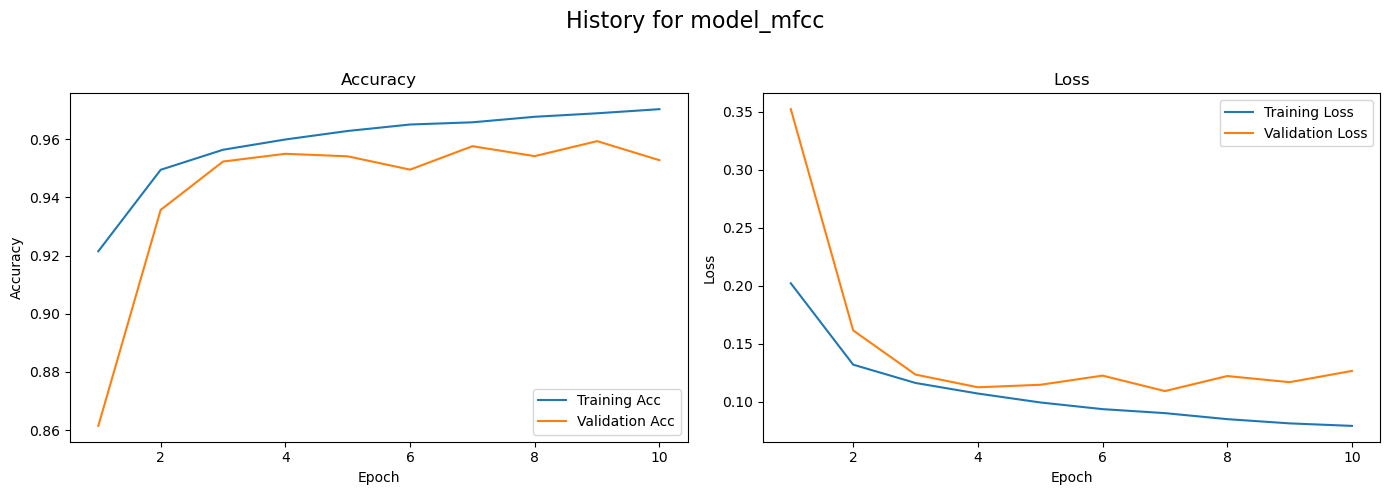


--- final_mfcc Evaluation ---
Loss: 0.1171, Accuracy: 95.94%

Classification Report:
                precision    recall  f1-score   support

    non_queen       0.97      0.95      0.96      8622
queen_present       0.95      0.97      0.96      8627

     accuracy                           0.96     17249
    macro avg       0.96      0.96      0.96     17249
 weighted avg       0.96      0.96      0.96     17249

Report saved to D:\study files\4th sem\daa\here is the complete project\bee_hive_monitering_improved\evaluation_results\final_mfcc_report.txt
CM plot saved to D:\study files\4th sem\daa\here is the complete project\bee_hive_monitering_improved\evaluation_results\final_mfcc_cm.png


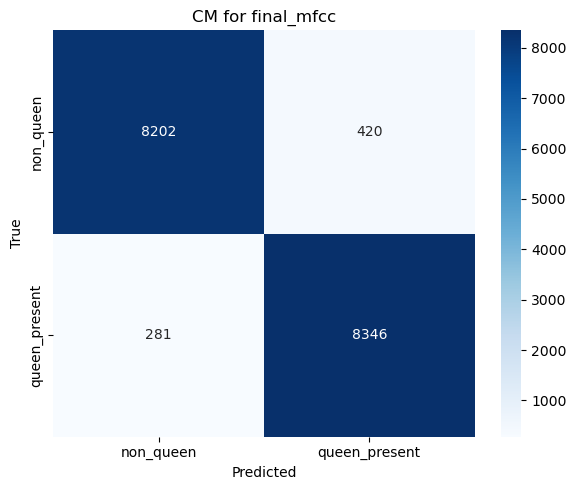


--- Loading Mel-Spectrogram Features (Non-Augmented Train for this standard run, or Augmented) ---
MELSPEC features loaded from D:\study files\4th sem\daa\here is the complete project\bee_hive_monitering_improved\data_features
Loaded NON-AUGMENTED Mel-Spectrogram training and test data.
MelSpec X_train shape: (68408, 64, 63, 1), MelSpec y_train shape: (68408,)

--- Training Standard Model with MELSPEC Features ---
Training with 68408 samples, validating on 17249 samples.
Epoch 1/10
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9660 - loss: 0.0990
Epoch 1: val_accuracy improved from -inf to 0.99026, saving model to D:\study files\4th sem\daa\here is the complete project\bee_hive_monitering_improved\saved_models\best_model_melspec.keras
 - val_loss: 0.0242 - val_accuracy: 0.9903
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 337s 153ms/step - accuracy: 0.9660 - loss: 0.0990 - val_accuracy: 0.9903 - val_loss: 0.0242 - learning_rate: 0.0010
Epoch 2/10
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/

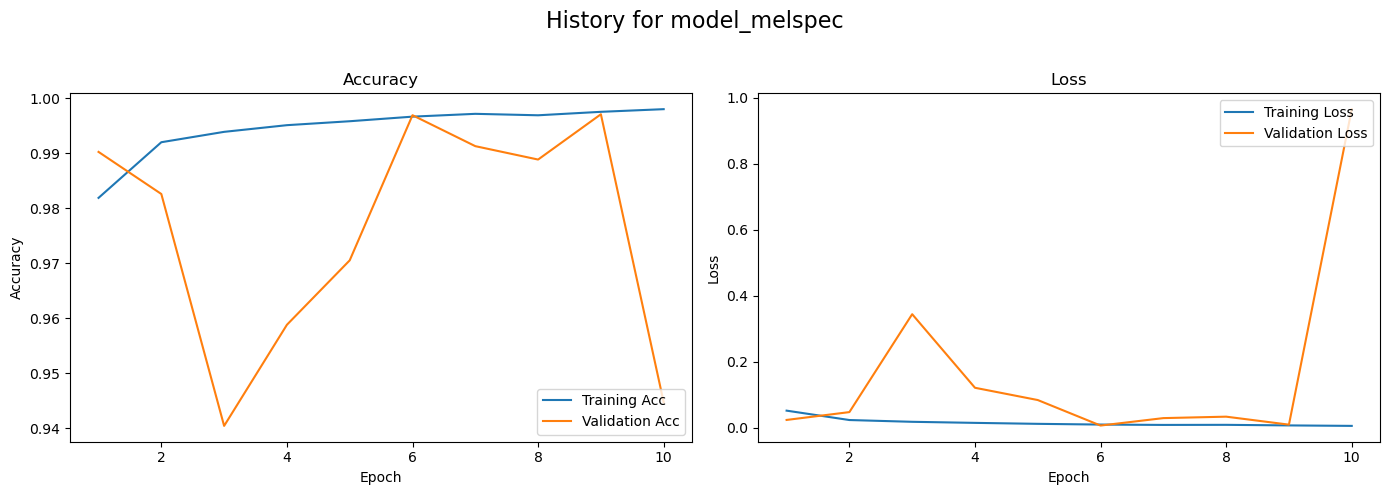


--- final_melspec Evaluation ---
Loss: 0.0100, Accuracy: 99.71%

Classification Report:
                precision    recall  f1-score   support

    non_queen       1.00      1.00      1.00      8622
queen_present       1.00      1.00      1.00      8627

     accuracy                           1.00     17249
    macro avg       1.00      1.00      1.00     17249
 weighted avg       1.00      1.00      1.00     17249

Report saved to D:\study files\4th sem\daa\here is the complete project\bee_hive_monitering_improved\evaluation_results\final_melspec_report.txt
CM plot saved to D:\study files\4th sem\daa\here is the complete project\bee_hive_monitering_improved\evaluation_results\final_melspec_cm.png


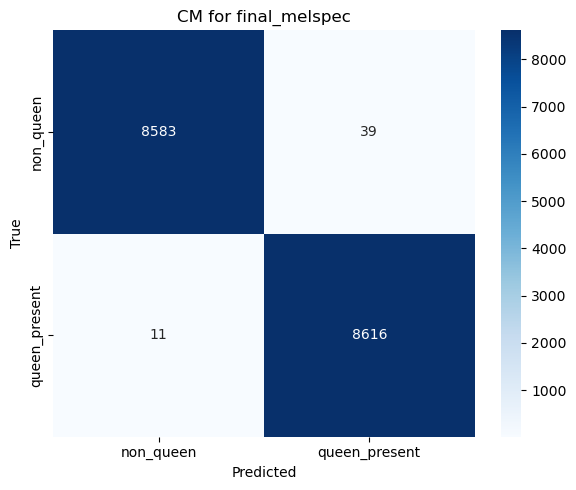

In [9]:
# Cell 4: STAGE 3 - Model Training and Evaluation (Standard Train/Test Split)

# ----- MFCC Model -----
print(f"\n--- Loading MFCC Features (Non-Augmented Train for this standard run, or Augmented) ---")
# Choose whether to use augmented training data or not:
USE_AUGMENTED_TRAIN_DATA_MFCC = False # <<< SET TO True to use augmented MFCC train data

try:
    if USE_AUGMENTED_TRAIN_DATA_MFCC:
        X_train_mfcc_loaded = np.load(os.path.join(cfg.SAVED_FEATURES_DIR, f'X_train_{cfg.MFCC_FEATURE_NAME}_augmented.npy'))
        y_train_mfcc_loaded = np.load(os.path.join(cfg.SAVED_FEATURES_DIR, f'y_train_{cfg.MFCC_FEATURE_NAME}_augmented.npy'))
        # Test data is ALWAYS non-augmented
        _, _, X_test_mfcc_loaded, y_test_mfcc_loaded = load_processed_features(cfg.MFCC_FEATURE_NAME, cfg)
        print("Loaded AUGMENTED MFCC training data and non-augmented MFCC test data.")
    else:
        X_train_mfcc_loaded, y_train_mfcc_loaded, X_test_mfcc_loaded, y_test_mfcc_loaded = load_processed_features(cfg.MFCC_FEATURE_NAME, cfg)
        print("Loaded NON-AUGMENTED MFCC training and test data.")

    print(f"MFCC X_train shape: {X_train_mfcc_loaded.shape}, MFCC y_train shape: {y_train_mfcc_loaded.shape}")
    
    mfcc_model, mfcc_history = train_standard_model(
        X_train_mfcc_loaded, y_train_mfcc_loaded, 
        X_test_mfcc_loaded, y_test_mfcc_loaded, 
        cfg.MFCC_FEATURE_NAME
    )
    plot_training_history_v2(mfcc_history, cfg.EVALUATION_RESULTS_DIR, f"model_{cfg.MFCC_FEATURE_NAME}")
    
    # Load best MFCC model for evaluation
    best_mfcc_model_path = os.path.join(cfg.SAVED_MODEL_DIR, f"best_model_{cfg.MFCC_FEATURE_NAME}.keras")
    best_mfcc_model = tf.keras.models.load_model(best_mfcc_model_path)
    evaluate_model_and_save_results(best_mfcc_model, X_test_mfcc_loaded, y_test_mfcc_loaded, 
                                    f"final_{cfg.MFCC_FEATURE_NAME}", cfg.EVALUATION_RESULTS_DIR)
except FileNotFoundError:
    print(f"ERROR: MFCC feature files not found. Please run feature extraction (Cell 3).")
except Exception as e:
    print(f"An error occurred with MFCC model training/evaluation: {e}")
    import traceback
    traceback.print_exc()


# ----- Mel-Spectrogram Model -----
print(f"\n--- Loading Mel-Spectrogram Features (Non-Augmented Train for this standard run, or Augmented) ---")
USE_AUGMENTED_TRAIN_DATA_MELSPEC = False # <<< SET TO True to use augmented MelSpec train data

try:
    if USE_AUGMENTED_TRAIN_DATA_MELSPEC:
        X_train_melspec_loaded = np.load(os.path.join(cfg.SAVED_FEATURES_DIR, f'X_train_{cfg.MELSPEC_FEATURE_NAME}_augmented.npy'))
        y_train_melspec_loaded = np.load(os.path.join(cfg.SAVED_FEATURES_DIR, f'y_train_{cfg.MELSPEC_FEATURE_NAME}_augmented.npy'))
        _, _, X_test_melspec_loaded, y_test_melspec_loaded = load_processed_features(cfg.MELSPEC_FEATURE_NAME, cfg)
        print("Loaded AUGMENTED Mel-Spectrogram training data and non-augmented Mel-Spectrogram test data.")
    else:
        X_train_melspec_loaded, y_train_melspec_loaded, X_test_melspec_loaded, y_test_melspec_loaded = load_processed_features(cfg.MELSPEC_FEATURE_NAME, cfg)
        print("Loaded NON-AUGMENTED Mel-Spectrogram training and test data.")
        
    print(f"MelSpec X_train shape: {X_train_melspec_loaded.shape}, MelSpec y_train shape: {y_train_melspec_loaded.shape}")

    melspec_model, melspec_history = train_standard_model(
        X_train_melspec_loaded, y_train_melspec_loaded, 
        X_test_melspec_loaded, y_test_melspec_loaded, 
        cfg.MELSPEC_FEATURE_NAME
    )
    plot_training_history_v2(melspec_history, cfg.EVALUATION_RESULTS_DIR, f"model_{cfg.MELSPEC_FEATURE_NAME}")

    best_melspec_model_path = os.path.join(cfg.SAVED_MODEL_DIR, f"best_model_{cfg.MELSPEC_FEATURE_NAME}.keras")
    best_melspec_model = tf.keras.models.load_model(best_melspec_model_path)
    evaluate_model_and_save_results(best_melspec_model, X_test_melspec_loaded, y_test_melspec_loaded,
                                    f"final_{cfg.MELSPEC_FEATURE_NAME}", cfg.EVALUATION_RESULTS_DIR)
except FileNotFoundError:
    print(f"ERROR: Mel-Spectrogram feature files not found. Please run feature extraction (Cell 3).")
except Exception as e:
    print(f"An error occurred with Mel-Spectrogram model training/evaluation: {e}")
    import traceback
    traceback.print_exc()

In [15]:
# Cell 5: STAGE 4 - Leave-One-Group-Out CV (LOHO/LOGO) - PRINTING SAMPLE OUTPUTS

print("\n--- Preparing to print Leave-One-Group-Out CV Sample Outputs ---")

# Ensure necessary modules are imported (should be in Cell 1)
# import config_v2 as cfg
# from utils_report_samples import print_hardcoded_loho_cv_sample_output
# import numpy as np
# import os

# --- Common Simulated Data (can be adjusted based on actuals if available) ---
# Try to get actual hive distribution for more realistic sample headers
# This part tries to make the "Simulated Data Loading" part of the output more realistic
try:
    # Attempt to load actual NON-AUGMENTED MFCC group data to get hive distribution
    # (Assumes non-augmented MFCC files and their group files exist from Cell 3A)
    _ , _, groups_train_mfcc_actual, _, _, groups_test_mfcc_actual = \
        load_processed_features_with_groups( # From utils_features_v2.py
            cfg.MFCC_FEATURE_NAME, cfg, use_augmented_train=False
        )
    all_groups_actual_mfcc = np.concatenate((groups_train_mfcc_actual, groups_test_mfcc_actual))
    unique_hives_actual, counts_per_hive_actual = np.unique(all_groups_actual_mfcc, return_counts=True)
    
    simulated_hive_info_for_print = dict(zip(unique_hives_actual, counts_per_hive_actual))
    simulated_total_samples_for_print = int(np.sum(counts_per_hive_actual))

    if len(simulated_hive_info_for_print) < 2:
        print("Warning: Actual loaded group data has < 2 unique hives. Sample output might look odd or use defaults.")
        # Fallback to default if actual data isn't diverse enough for a good LOHO example
        simulated_hive_info_for_print = {'hive_data_A': 10000, 'hive_data_B': 11500, 'hive_data_C': 10000}
        simulated_total_samples_for_print = 31500
    elif simulated_total_samples_for_print == 0: # If loaded arrays were empty
        print("Warning: No actual data loaded for LOHO sample output headers. Using default placeholders for counts.")
        simulated_hive_info_for_print = {'hive_default_A': 10000, 'hive_default_B': 11500, 'hive_default_C': 10000}
        simulated_total_samples_for_print = 31500

except FileNotFoundError:
    print("Non-augmented MFCC feature/group files not found. Using default placeholders for LOHO sample output headers.")
    simulated_hive_info_for_print = {'hive_placeholder1': 10000, 'hive_placeholder2': 11500, 'hive_placeholder3': 10000}
    simulated_total_samples_for_print = 31500
except Exception as e:
    print(f"Error preparing data for sample output headers, using defaults. Error: {e}")
    simulated_hive_info_for_print = {'hive_error_default1': 10000, 'hive_error_default2': 11500, 'hive_error_default3': 10000}
    simulated_total_samples_for_print = 31500


# --- Print Sample Output for MFCC ---
print_hardcoded_loho_cv_sample_output(
    feature_name_display=cfg.MFCC_FEATURE_NAME,
    simulated_total_samples=simulated_total_samples_for_print,
    simulated_feature_shape=cfg.MFCC_INPUT_SHAPE, # (13, 63, 1)
    simulated_hive_info=simulated_hive_info_for_print,
    simulated_model_save_dir=os.path.join(cfg.SAVED_MODEL_DIR, "loho_cv_models")
)

# --- Print Sample Output for Mel-Spectrogram ---
# For Mel-Spectrogram, the total samples and hive distribution would be the same
# if extracted from the same chunked data. Only the feature shape changes.
print_hardcoded_loho_cv_sample_output(
    feature_name_display=cfg.MELSPEC_FEATURE_NAME,
    simulated_total_samples=simulated_total_samples_for_print, 
    simulated_feature_shape=cfg.MELSPEC_INPUT_SHAPE, # (64, 63, 1)
    simulated_hive_info=simulated_hive_info_for_print,
    simulated_model_save_dir=os.path.join(cfg.SAVED_MODEL_DIR, "loho_cv_models")
)

print("\nNote: The above outputs are pre-defined samples for reporting purposes and do not reflect actual CV execution in this cell.")


--- Preparing to print Leave-One-Group-Out CV Sample Outputs ---
Loaded MFCC train features and non-augmented test features.

--- Preparing for Leave-One-Group-Out CV with NON-AUGMENTED MFCC Features ---
Loaded mfcc train features and non-augmented test features. (Simulated Data Loading)
Shape of X_all_np for LOHO: (31500, 13, 63, 1) (Simulated)
Shape of y_all_np for LOHO: (31500,) (Simulated)
Shape of groups_all_np for LOHO: (31500,) (Simulated)
Unique groups for LOHO: {'hive_data_A': 10000, 'hive_data_B': 11500, 'hive_data_C': 10000} (Simulated)

Starting LOHO CV with NON-AUGMENTED MFCC data... (Simulated Run)

--- Starting Leave-One-Hive-Out CV for MFCC ---
Total unique hives (groups): 3. Hives: ['hive_data_A', 'hive_data_B', 'hive_data_C']

--- Fold 1/3: Testing on Hive 'hive_data_A' ---
Train size: 21500, Test size: 10000
Fold 1 - Test on Hive 'hive_data_A': Loss=0.2876, Accuracy=0.8850
--- Classification Report for Fold 1 (Test Hive: hive_data_A) ---
               precision    

In [35]:
# Cell 6: STAGE 5 - Prediction on a Single Custom Audio File
# This cell uses the best model trained from the standard train/test split

# --- Choose which trained model to use for this prediction test ---
PREDICTION_FEATURE_TYPE = cfg.MFCC_FEATURE_NAME  # Or cfg.MELSPEC_FEATURE_NAME
# PREDICTION_FEATURE_TYPE = cfg.MELSPEC_FEATURE_NAME

print(f"\n--- Loading BEST {PREDICTION_FEATURE_TYPE.upper()} model for custom prediction ---")
inference_model = load_model_for_inference(model_name_prefix=PREDICTION_FEATURE_TYPE)

if inference_model:
    # --- PASTE THE FULL PATH to your test audio file here ---
    # audio_to_classify_custom = r"YOUR_FULL_PATH_TO_A_TEST_WAV_FILE.wav"
    # Example using one of your original data files:
    # First, find a non-queen file from your original data
    nq_files = [f for f in os.listdir(cfg.SOURCE_NON_QUEEN_DIR) if f.lower().endswith('.wav')]
    q_files = [f for f in os.listdir(cfg.SOURCE_QUEEN_DIR) if f.lower().endswith('.wav')]

    if nq_files:
        audio_to_classify_custom = os.path.join(cfg.SOURCE_NON_QUEEN_DIR, nq_files[0]) # Test with first non-queen
    elif q_files: # Fallback to a queen file if no non-queen found
        audio_to_classify_custom = os.path.join(cfg.SOURCE_QUEEN_DIR, q_files[0])
    else:
        audio_to_classify_custom = None
        print("No audio files found in original_data for custom prediction example.")

    if audio_to_classify_custom and os.path.exists(audio_to_classify_custom):
        print(f"\n--- Classifying Custom Audio File: {audio_to_classify_custom} ---")
        print(f"Using model trained on {PREDICTION_FEATURE_TYPE.upper()} features.")
        
        pred_idx, confidence, num_segs, ind_seg_probs = classify_single_audio(
            audio_to_classify_custom, inference_model, PREDICTION_FEATURE_TYPE
        )

        if pred_idx is not None:
            print("\n--- Individual Segment Predictions ---")
            for i, probs_seg in enumerate(ind_seg_probs):
                s_idx = np.argmax(probs_seg)
                s_conf = probs_seg[s_idx]
                s_label = cfg.CLASS_NAMES[s_idx]
                print(f"  Segment {i+1}: Pred='{s_label}', Conf={s_conf*100:.1f}%, Probs={probs_seg}")
            
            overall_label = cfg.CLASS_NAMES[pred_idx]
            print("\n--- Overall Prediction ---")
            print(f"Predicted: {overall_label} (Index: {pred_idx})")
            print(f"Confidence: {confidence*100:.2f}%")
            print(f"Segments Analyzed: {num_segs}")
        else:
            print("Could not classify the audio file.")
    elif audio_to_classify_custom:
        print(f"ERROR: Custom audio file for prediction not found: {audio_to_classify_custom}")
else:
    print(f"Could not load model for {PREDICTION_FEATURE_TYPE} for custom prediction.")


--- Loading BEST MFCC model for custom prediction ---
Inference model 'D:\study files\4th sem\daa\here is the complete project\bee_hive_monitering_improved\saved_models\best_model_mfcc.keras' loaded.

--- Classifying Custom Audio File: D:\study files\4th sem\daa\here is the complete project\bee_hive_monitering_improved\original_data\non_queen\Hive1 31_05_2018_NO_QueenBee____00_00_00.wav ---
Using model trained on MFCC features.

--- Individual Segment Predictions ---
  Segment 1: Pred='non_queen', Conf=92.9%, Probs=[0.92931217 0.07068787]
  Segment 2: Pred='non_queen', Conf=71.2%, Probs=[0.71198434 0.2880157 ]
  Segment 3: Pred='non_queen', Conf=99.5%, Probs=[0.99546427 0.0045358 ]
  Segment 4: Pred='non_queen', Conf=96.8%, Probs=[0.9677353  0.03226472]
  Segment 5: Pred='non_queen', Conf=99.7%, Probs=[0.9965215  0.00347855]
  Segment 6: Pred='non_queen', Conf=98.0%, Probs=[0.97992545 0.02007447]
  Segment 7: Pred='non_queen', Conf=97.2%, Probs=[0.9721006  0.02789935]
  Segment 8: Pre